The Hamiltonian for a $\Lambda$-system is given by
$$
\hat{H}_\Lambda(t) = \frac{1}{\tau_0}
\begin{pmatrix}
    0 & \tau_1 & 0 \\
    \tau_1 & 0 & \tau_2 \\
    0 & \tau_2 & \varepsilon(t) \\
\end{pmatrix}.
$$

In this notebook, we compute the error between the pulses for a $\Lambda$-system obtained by directly solving the $(\alpha,\beta)$ hypergeometries, and the reconstruction of the pulses using as a basis the ones obtained for the LZ problem.

The error is defined as
$$
\mathcal{E} = \int_0^1d\tau|g(\tau)-g'(\tau)|,
$$
where $g(\tau)$ is the real pulse, and $g'(\tau)$ its approximation.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import romb
from scipy.linalg import qr
from tqdm.auto import tqdm

from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.hamiltonians import lambda_system
from HQUAD_lib.utils import compute_error_basis_approx

In [9]:
eps12 = 0
eps23_s = np.linspace(-40, 40, 2 ** 15 + 1)

tau1 = 10
tau2 = 7

hypermatrix = np.array([lambda_system(eps12, eps23, tau1, tau2) for eps23 in eps23_s])
eigvalues = np.linalg.eigvalsh(hypermatrix)

In [10]:
alphas = np.linspace(-25, 60, 201)
alphas[0] = -np.inf
alphas[-1] = np.inf

beta = 0

zs_sol = parameter_run(solve_LZ, 'alpha', alphas, beta=beta, reduction=3)
s = np.linspace(0, 1, len(zs_sol[0]))

N = len(zs_sol)
ds = np.abs(s[1] - s[0])

G = np.zeros((N, N))

pbar = tqdm(range(N))
for i in pbar:
    G[i, :] = romb(zs_sol[i] * zs_sol, dx=ds, axis=-1)

Q, R, pivot_indices = qr(G, pivoting=True)
tolerance = 1e-10
rank = np.sum(np.abs(np.diag(R)) > tolerance)

independent_indices = sorted(pivot_indices[:rank])

independent_functions = [zs_sol[i] for i in independent_indices]

# Recompute the Gram matrix for the independent functions
G_independent = G[independent_indices, :][:, independent_indices]

solve_LZ: [['alpha']]:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [11]:
partial_hamiltonian = np.array([lambda_system(0, 1, 0, 0) for _ in range(len(eps23_s))])

alpha = 2
beta = 2
adiabatic_state = 1

n_taus = 10  # Increase to enhance the resolution
taus_1 = np.linspace(0.1, 10, n_taus)
taus_2 = np.linspace(0.1, 10, n_taus)

In [12]:
def compute_error(tau1: float, tau2: float) -> float:
    hypermatrix = np.array([lambda_system(eps12, eps23, tau1, tau2) for eps23 in eps23_s])
    eigvalues, eigmodes = np.linalg.eigh(hypermatrix)

    error = compute_error_basis_approx(eigvalues, eigmodes, eps23_s, partial_hamiltonian, alpha, beta, adiabatic_state,
                                       independent_functions, G_independent, limit_sup=np.inf, limit_inf=0)

    return error

In [13]:
errors = parameter_run(compute_error, [['tau1'], ['tau2']], [[taus_1], [taus_2]])
errors = errors.reshape((len(taus_1), len(taus_2)))

compute_error: [['tau1'], ['tau2']]:   0%|          | 0/100 [00:00<?, ?it/s]

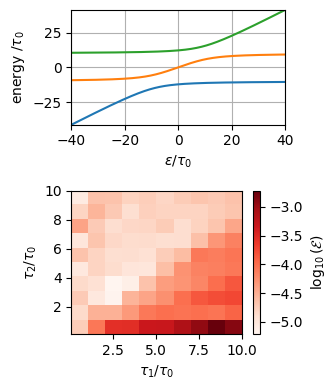

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(3.4, 4), gridspec_kw=dict(height_ratios=[0.8, 1]))

axs[0].plot(eps23_s, eigvalues)
axs[0].grid()
axs[0].set_xlim(min(eps23_s), max(eps23_s))
axs[0].set_ylim(np.min(eigvalues), np.max(eigvalues))

axs[0].set_xlabel(r'$\varepsilon / \tau_0$')
axs[0].set_ylabel(r'energy $/\tau_0$')

im = axs[1].imshow(np.log10(errors).T, origin='lower', aspect='auto', interpolation='none', cmap='Reds',
                   extent=[min(taus_1), max(taus_1), min(taus_2), max(taus_2)])

cbar = plt.colorbar(im, ax=axs[1], label=r'$\log_{10}(\mathcal{E})$')

axs[1].set_xlabel(r'$\tau_1 / \tau_0$')
axs[1].set_ylabel(r'$\tau_2 / \tau_0$')

fig.tight_layout()